In [29]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from collections import namedtuple

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [30]:
# class EnhancedConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride, dropout):
#         super().__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2)
#         self.batchnorm = nn.BatchNorm2d(num_features=out_channels)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.batchnorm(x)
#         x = self.relu(x)
#         return self.dropout(x)

# class EnhancedConvNet(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()
#         #self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#         # Add more layers and increase complexity
#         self.layer1 = EnhancedConvBlock(in_channels, 32, kernel_size=3, stride=1, dropout=0.5)
#         self.layer2 = EnhancedConvBlock(32, 64, kernel_size=3, stride=1, dropout=0.5)
#         # self.layer3 = ResidualBlock(256, 256, kernel_size=3, stride=1, dropout=0.25)
#         # self.layer4 = ResidualBlock(256, 256, kernel_size=3, stride=1, dropout=0.25)
#         # self.layer5 = ResidualBlock(256, 256, kernel_size=3, stride=1, dropout=0.25)
#         self.layer3 = EnhancedConvBlock(64, 128, kernel_size=3, stride=1, dropout=0.25)
#         self.layer4 = EnhancedConvBlock(128, 256, kernel_size=3, stride=1, dropout=0.25)
#         self.layer5 = EnhancedConvBlock(256, 512, kernel_size=3, stride=1, dropout=0.25)

#         # Adaptive pooling layer remains the same
#         self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

#         # Flatten layer
#         self.flatten = nn.Flatten()

#         # Dropout
#         # self.dropout =nn.Dropout(0.5)
#         # Fully connected layers
#         # self.fc1 = nn.Linear(256, 128)
#         #self.fc2 = nn.Linear(256, 64)
#         #self.fc3 = nn.Linear(128,64)
#         self.fc4 = nn.Linear(512, num_classes)

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = self.adaptive_pool(x)
#         x = self.flatten(x)
#         #x = F.relu(self.fc1(x))
#         #x = self.dropout(x)
#         # x = F.relu(self.fc2(x))
#         # x = self.dropout(x)
#         #x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x
class EnhancedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dropout):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return self.dropout(x)


class EnhancedConvNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Add more layers and increase complexity
        self.layer1 = EnhancedConvBlock(in_channels, 64, kernel_size=3, stride=1, dropout=0.25)
        self.layer2 = EnhancedConvBlock(64, 64, kernel_size=3, stride=2, dropout=0.25)
        self.layer3 = EnhancedConvBlock(64, 128, kernel_size=3, stride=1, dropout=0.25)
        self.layer4 = EnhancedConvBlock(128, 128, kernel_size=3, stride=2, dropout=0.25)
        self.layer5 = EnhancedConvBlock(128, 256, kernel_size=3, stride=1, dropout=0.25)
        self.layer6 = EnhancedConvBlock(256, 256, kernel_size=3, stride=1, dropout=0.25)
        self.layer7 = EnhancedConvBlock(256, 256, kernel_size=3, stride=2, dropout=0.25)

        # Adaptive pooling layer remains the same
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
#        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        #x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [31]:
def regression_accuracy(output, target, threshold=0.1):
    """
    Calculate the 'accuracy' for a regression task. A prediction is considered
    correct if it's within a specified threshold of the actual value.

    Parameters:
    output (torch.Tensor): The model's predictions.
    target (torch.Tensor): The actual values.
    threshold (float): The acceptable relative error for a prediction to be considered correct.

    Returns:
    float: The 'accuracy' of the predictions.
    """
    correct = torch.abs((output - target) / target) < threshold
    accuracy = torch.mean(correct.float()) * 100
    return accuracy.item()

In [32]:
def l1_l2_loss(pred, true, l1_weight):
    rmse_loss = torch.sqrt(torch.mean((pred - true) ** 2))
    mse_loss = torch.mean((pred - true) ** 2)
    # if l1_weight > 0:
    #     l1 = F.l1_loss(pred, true)
    #     loss = mse_loss * (1 - l1_weight) + l1 * l1_weight
    return mse_loss

In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dropout):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = EnhancedConvBlock(in_channels, out_channels, kernel_size, stride, dropout)
        self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [34]:
# Define training function
def train_model(model, train_loader, val_loader, epochs, learning_rate, weight_decay, patience, device):
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizer =torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9,weight_decay=weight_decay)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    best_val_loss = np.inf
    train_losses, val_losses, train_rmse, val_rmse = [], [], [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        total_loss, total_train_rmse = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = l1_l2_loss(outputs, targets, l1_weight=0.5)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_train_rmse += torch.sqrt(torch.mean((outputs - targets) ** 2)).item()

        avg_train_loss = total_loss / len(train_loader)
        avg_train_rmse = total_train_rmse/ len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss, total_val_rmse = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss = l1_l2_loss(outputs, targets, l1_weight=0.5)
                total_val_loss += val_loss.item()
                total_val_rmse += torch.sqrt(torch.mean((outputs - targets) ** 2)).item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_rmse = total_val_rmse/ len(val_loader)

        # Scheduler step
        # scheduler.step(avg_val_loss)

        # Update best validation accuracy and save model state
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), Path("model.pth"))
            patience_counter = 0
        else:
            # print("best validation loss is: ", best_val_loss)
            patience_counter += 1
            if patience_counter > patience:
                print("Early stopping")
                break
        # Append losses and accuracies for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_rmse.append(avg_train_rmse)
        val_rmse.append(avg_val_rmse)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Training RMSE: {avg_train_rmse:.4f}')
        print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Validation RMSE: {avg_val_rmse:.4f}')

    # Plot the training and validation loss
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim(bottom=0, top=2000)
    plt.title('Loss Curve')
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_rmse, label='Train RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('RMSE Curve')
    plt.legend()

    plt.savefig("training_performance.png")

    return train_losses, val_losses, train_rmse, val_rmse


Image inside histogram size:  2098
Train images size:  2004
Epoch 1/2000, Train Loss: 2769.7127, Training RMSE: 44.2172
Epoch 1/2000, Validation Loss: 780.4637, Validation RMSE: 26.3558
Epoch 2/2000, Train Loss: 939.4994, Training RMSE: 29.3812
Epoch 2/2000, Validation Loss: 590.2562, Validation RMSE: 23.3804
Epoch 3/2000, Train Loss: 982.6900, Training RMSE: 29.7538
Epoch 3/2000, Validation Loss: 612.9900, Validation RMSE: 23.5328
Epoch 4/2000, Train Loss: 678.7154, Training RMSE: 25.0288
Epoch 4/2000, Validation Loss: 483.2932, Validation RMSE: 20.9182
Epoch 5/2000, Train Loss: 669.6811, Training RMSE: 24.8403
Epoch 5/2000, Validation Loss: 478.8483, Validation RMSE: 20.9114
Epoch 6/2000, Train Loss: 593.7303, Training RMSE: 23.4774
Epoch 6/2000, Validation Loss: 451.4782, Validation RMSE: 20.4462
Epoch 7/2000, Train Loss: 521.4288, Training RMSE: 21.8389
Epoch 7/2000, Validation Loss: 427.3487, Validation RMSE: 19.6999
Epoch 8/2000, Train Loss: 527.6495, Training RMSE: 22.0075
Epoch

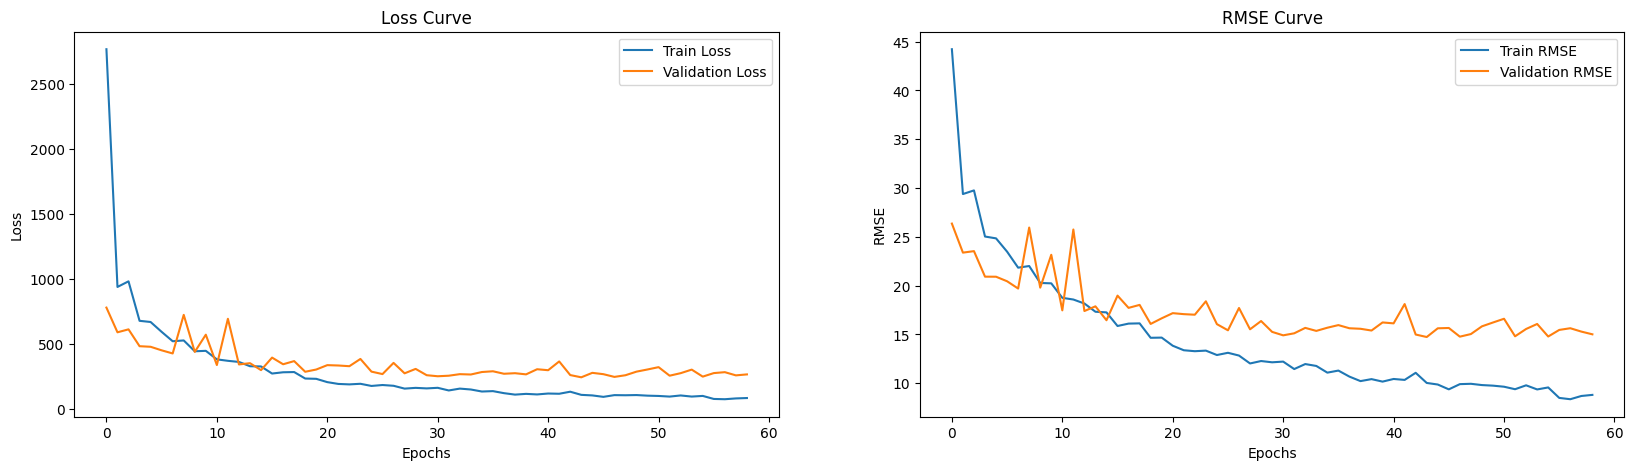

In [35]:
# Load data
data = np.load('/content/drive/MyDrive/Colab Notebooks/histogram_all_full.npz')
images = data['output_image']
print("Image inside histogram size: ", len(images))
yields = data['output_yield']
years = data['output_year']

# Normalize images
# images = (images - images.mean(axis=(0, 2, 3), keepdims=True))
# Normalize images
# Calculate mean and standard deviation for normalization
epsilon = 1e-10
mean = images.mean(axis=(0, 2, 3), keepdims=True)
std = images.std(axis=(0, 2, 3), keepdims=True) + epsilon
# Apply normalization: (X - mean) / std
images_normalized = (images - mean) / std

# Split the data into training and validation sets
train_indices = (years >= 2001) & (years <= 2021)
test_indices = years == 2022
train_images, test_images = images_normalized[train_indices], images_normalized[test_indices]
train_yields, test_yields = yields[train_indices], yields[test_indices]

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_yields_tensor = torch.tensor(train_yields, dtype=torch.float32).view(-1, 1)
# test data
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_yields_tensor = torch.tensor(test_yields, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
# train_dataset_1 = TensorDataset(train_images_tensor, train_yields_tensor)
total_size = len(train_images_tensor)
print("Train images size: ", total_size)
val_size = total_size // 5
train_size = total_size - val_size
train_dataset, val_dataset = random_split(TensorDataset(train_images_tensor, train_yields_tensor),
                                          (train_size, val_size))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the enhanced model
model = EnhancedConvNet(in_channels=12, num_classes=1)
model.to(device)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=2000,  # Adjust as needed
    learning_rate=0.00001,  # Adjust as needed
    weight_decay=1e-3,  # Adjust as needed
    patience=15,  # Adjust as needed
    device=device
)
print(model)

# predict part
# testing dataset
test_dataset = TensorDataset(test_images_tensor, test_yields_tensor)
# testing loader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model.eval()
total_test_loss, total_test_rmse = 0, 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss = l1_l2_loss(outputs, targets, l1_weight=0.3)
        total_test_loss += test_loss.item()
        total_test_rmse += torch.sqrt(torch.mean((outputs - targets) ** 2)).item()

avg_test_loss = total_test_loss / len(test_loader)
avg_test_rmse = total_test_rmse / len(test_loader)
print(f'Prediction on 2022 Loss: {avg_test_loss:.4f}, RMSE: {avg_test_rmse:.4f}')